#  1- Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 4.8 MB/s 
     |████████████████████████████████| 58 kB 5.5 MB/s 
     |████████████████████████████████| 376 kB 30.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=9b9e29de841d012ecb8bc4d75c1e51c62aa3384647f30f2f2c21f899bcbcf637
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=bf44491673c5c289358c57f70dc1d0f8635cddb732895ab473b79f50c0f31046
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning ht

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

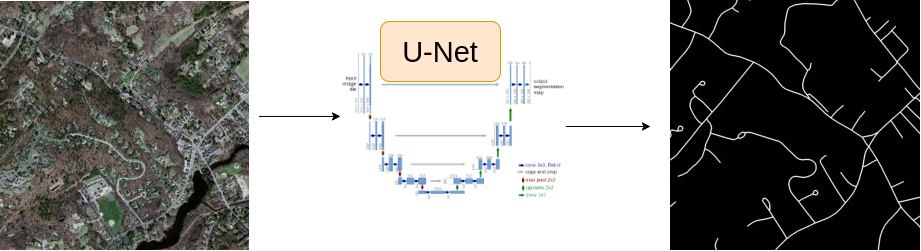

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 35.37 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (401/401), done.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# 2- Setup Configurations

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'
DEVICE = 'cuda'

EPOCHS = 15
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 2 

row = df.iloc[idx]

image_path = DATA_DIR + row.images

mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255


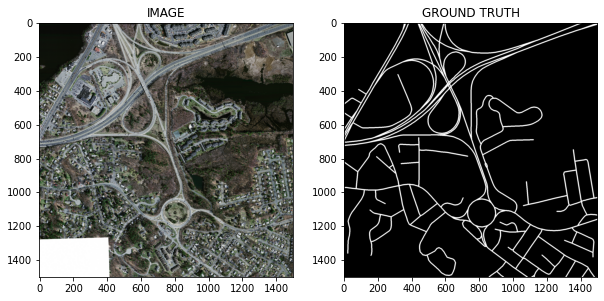

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

In [ ]:
len(train_df)

159

# 3- Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# 4- Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df =df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = df.iloc[idx]

    image_path = DATA_DIR + row.images

    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)#(h, w , c)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w)

    mask = np.expand_dims(mask, axis = -1) #(h, w , c)

    if self.augmentations:
        data = self.augmentations(image = image, mask=mask)
        image = data['image'] #(h, w , c)
        mask = data['mask']

    image = np.transpose(image, (2, 0 , 1)).astype(np.float32) #(h, w , c)
    mask = np.transpose(mask, (2, 0 , 1)).astype(np.float32)#(h, w , c)

    image = torch.Tensor(image)/ 255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask


In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs()) 
validset = SegmentationDataset(valid_df, get_valid_augs()) 

In [ ]:
print(f'Size of the trainset : {len(trainset)}')
print(f'Size of the validset : {len(validset)}')

Size of the trainset : 159
Size of the validset : 40


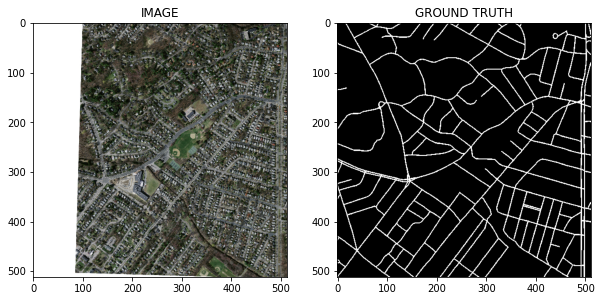

In [ ]:
# plot image from the trainset
idx = 8
image, mask = trainset[idx]

helper.show_image(image, mask)

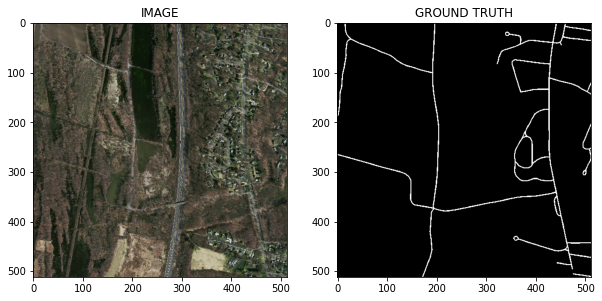

In [ ]:
# plot image from the validset
idx = 15
image, mask = validset[idx]

helper.show_image(image, mask)

# 5- Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f'Total number of batches in trainloader : {len(trainloader)}')
print(f'Total number of batches in validloader : {len(validloader)}')

Total number of batches in trainloader : 20
Total number of batches in validloader : 5


In [ ]:
for images, masks in trainloader:
  print(f"One batche image shape: {images.shape}")
  print(f"One batche mask shape: {masks.shape}")

  break;
#One batche image shape: torch.Size([ batch 8,channel 3,hight 512,width 512])

One batche image shape: torch.Size([8, 3, 512, 512])
One batche mask shape: torch.Size([8, 1, 512, 512])


# 6- Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch import nn

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name= ENCODER,
        encoder_weights= WEIGHTS,
        in_channels= 3 ,
        classes = 1,
        activation = None
    )
    
  def forward(self, images , masks =None):
    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16

# 7- Create Train and Validation Function 

In [ ]:
def train_fn(dataloader, model, optimizer):
  model.train() # Turn on dropout, batchnorm, etc

  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      optimizer.zero_grad()
      logits, loss = model(images, masks)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
  return total_loss / len(dataloader)

In [ ]:
def eval_fn(dataloader, model):
  model.eval() # Turn of dropout, batchnorm, etc

  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(dataloader):
    
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss / len(dataloader)

# 8- Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)
  
    if valid_loss < best_loss:
      torch.save(model.state_dict(), "best_model.pt")
      print("SAVED-MODEL")
      best_loss = valid_loss

    print(f'Epoch : {i+1} Train loss: {train_loss} Valid loss : {valid_loss}')


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


SAVED-MODEL
Epoch : 1 Train loss: 1.0506319165229798 Valid loss : 0.9738137364387512


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


SAVED-MODEL
Epoch : 2 Train loss: 0.7577793449163437 Valid loss : 0.8884630560874939


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


SAVED-MODEL
Epoch : 3 Train loss: 0.7020869523286819 Valid loss : 0.8043769717216491


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


SAVED-MODEL
Epoch : 4 Train loss: 0.6879711896181107 Valid loss : 0.7034672856330871


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


SAVED-MODEL
Epoch : 5 Train loss: 0.6530798256397248 Valid loss : 0.6193114876747131


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch : 6 Train loss: 0.6560379952192307 Valid loss : 0.7115770936012268


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


SAVED-MODEL
Epoch : 7 Train loss: 0.6394777655601501 Valid loss : 0.6164585709571838


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch : 8 Train loss: 0.6283097058534622 Valid loss : 0.6245863795280456


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


SAVED-MODEL
Epoch : 9 Train loss: 0.6240064948797226 Valid loss : 0.6117787837982178


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch : 10 Train loss: 0.6214608252048492 Valid loss : 0.6172045230865478


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


SAVED-MODEL
Epoch : 11 Train loss: 0.6217505156993866 Valid loss : 0.5675045788288117


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch : 12 Train loss: 0.6062019899487495 Valid loss : 0.5861497938632965


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch : 13 Train loss: 0.5953786298632622 Valid loss : 0.6206900835037231


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch : 14 Train loss: 0.603033846616745 Valid loss : 0.6081945240497589


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

SAVED-MODEL
Epoch : 15 Train loss: 0.605991342663765 Valid loss : 0.5563730716705322


# 9- Inference

In [ ]:
idx = 50

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]


logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) => (b, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0


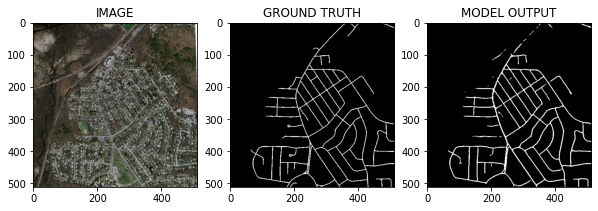

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0) )